In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

## Load and Preprocess the dataset

In [92]:
df = pd.read_csv(r"/content/automobiles.csv")
df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [93]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['Var_1'], df['Segmentation'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test p-value: {p}")
if p < 0.05:
    print("✅ There is a significant association between Var_1 and Segmentation.")
else:
    print("❌ No significant association between Var_1 and Segmentation.")


Chi-square test p-value: 1.646068148998022e-41
✅ There is a significant association between Var_1 and Segmentation.


Since p < 0.05, this means:

There is a statistically significant association between Var_1 and the target variable Segmentation.

In [94]:
df.isnull().sum()

,0
ID,0
Gender,0
Ever_Married,140
Age,0
Graduated,78
Profession,124
Work_Experience,829
Spending_Score,0
Family_Size,335
Var_1,76


In [95]:
print('Percentage of Null Values for each column')
df.isnull().mean()*100

Percentage of Null Values for each column


,0
ID,0.000000
Gender,0.000000
Ever_Married,1.735250
Age,0.000000
Graduated,0.966782
Profession,1.536936
Work_Experience,10.275161
Spending_Score,0.000000
Family_Size,4.152206
Var_1,0.941993


In [96]:
# Filling missing categorical columns with mode
categorical_cols = ['Ever_Married', 'Graduated', 'Profession', 'Var_1']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Filling numerical columns with median
numerical_cols = ['Work_Experience', 'Family_Size']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Double check if all missing values are handled
print(df.isnull().sum())

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64


In [97]:
df = df.drop(['ID'], axis=1)
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [98]:
df.shape

(8068, 10)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     8068 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        8068 non-null   object 
 4   Profession       8068 non-null   object 
 5   Work_Experience  8068 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      8068 non-null   float64
 8   Var_1            8068 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 630.4+ KB


In [100]:
df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,8068.000000
mean,43.466906,2.472980,2.856346
std,16.711696,3.265248,1.499577
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [101]:
df.describe(include='object').T

,count,unique,top,freq
Gender,8068,2,Male,4417
Ever_Married,8068,2,Yes,4783
Graduated,8068,2,Yes,5046
Profession,8068,9,Artist,2640
Spending_Score,8068,3,Low,4878
Var_1,8068,7,Cat_6,5314
Segmentation,8068,4,D,2268


-More males(4417) than females. This might slightly bias the segmentation.

-Majority are married.

-Graduates are more into the automobile than Non-Graduates.

-9 unique professions, with 'Artist' being the most common.

-Low spenders dominate, this can affect customer targeting strategies.

-'Cat_6' appears very frequently & Segment D has the most customers.

In [102]:
df.duplicated().sum()

np.int64(544)

In [103]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### **Handling Outliers**

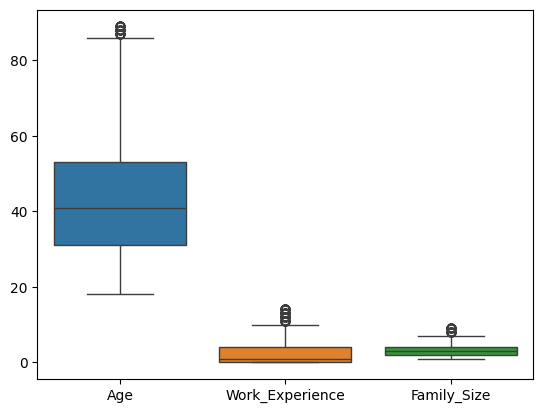

In [104]:
sns.boxplot(data=df[['Age', 'Work_Experience','Family_Size']])
plt.show()

In [105]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Apply capping
    df[col] = np.where(df[col] > upper_limit, upper_limit,
                       np.where(df[col] < lower_limit, lower_limit, df[col]))
    return df

# Apply winsorization to all 3 columns
for column in ['Age', 'Work_Experience', 'Family_Size']:
    df = cap_outliers(df, column)


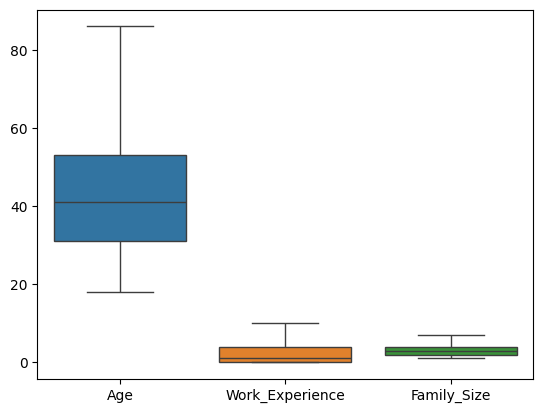

In [106]:
sns.boxplot(data=df[['Age', 'Work_Experience','Family_Size']])
plt.show()

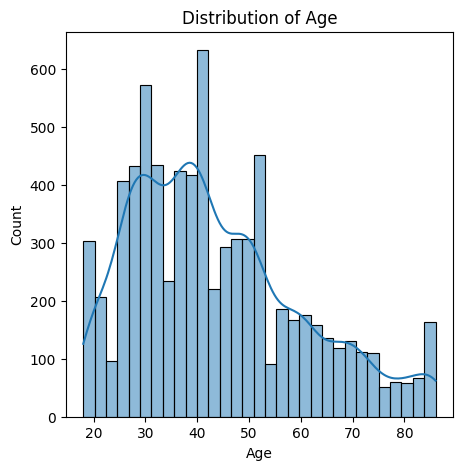

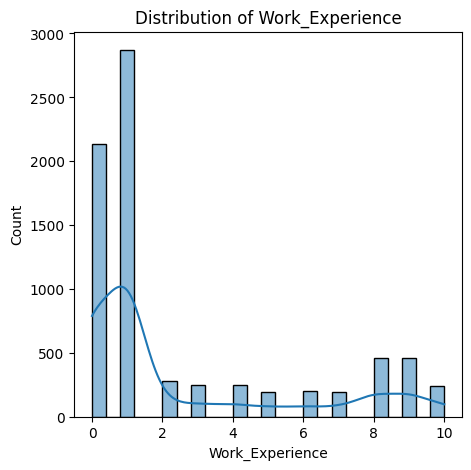

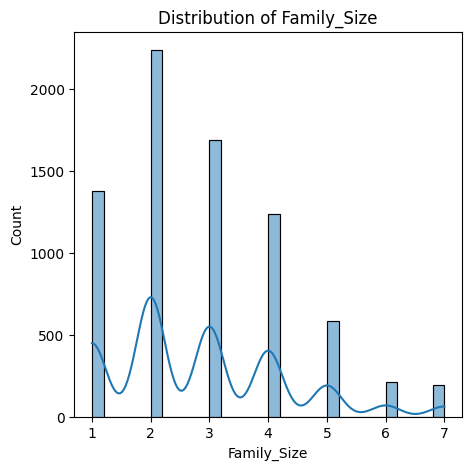

In [107]:
cols = ['Age', 'Work_Experience', 'Family_Size']
for col in cols:
 plt.figure(figsize=(5,5))
 sns.histplot(df[col], kde=True)
 plt.title(f"Distribution of {col}")
 plt.show()

# **Data Visualization**

## Univariate Analysis

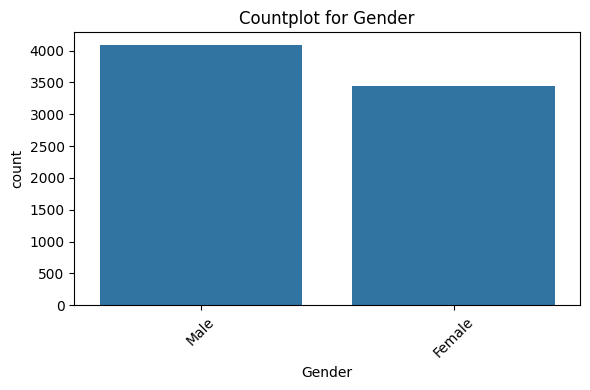

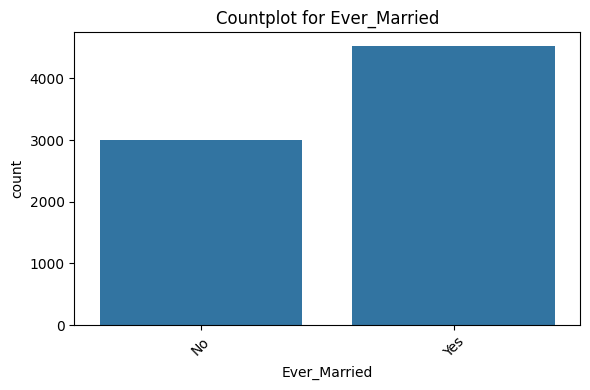

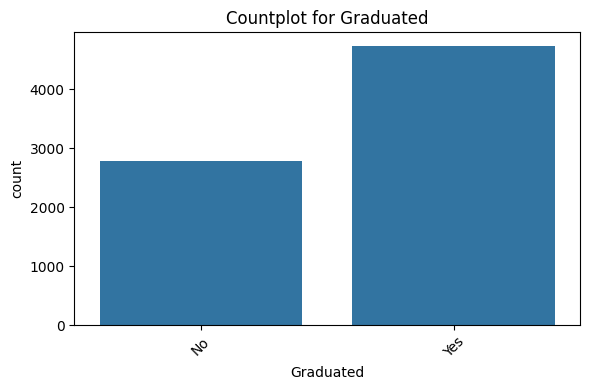

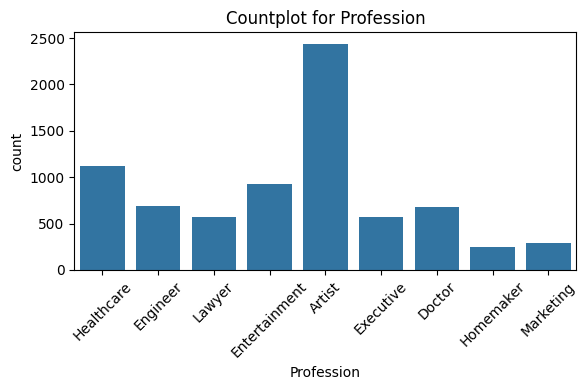

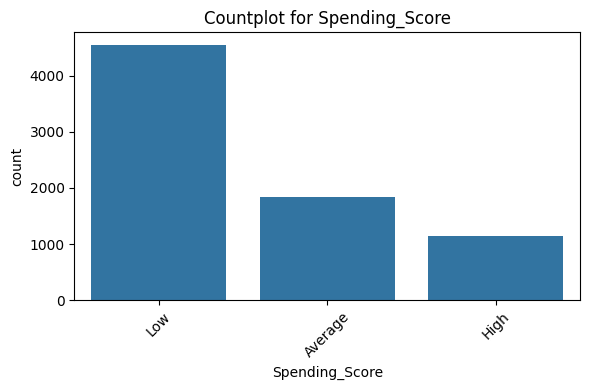

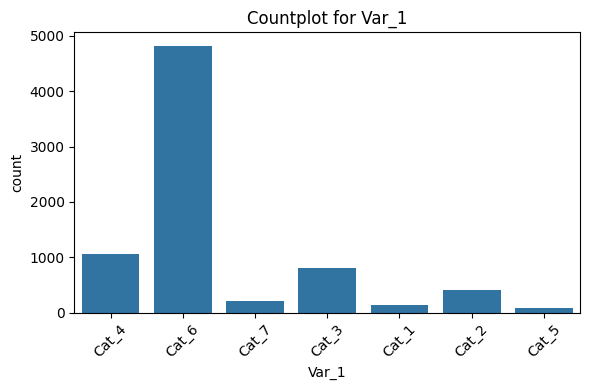

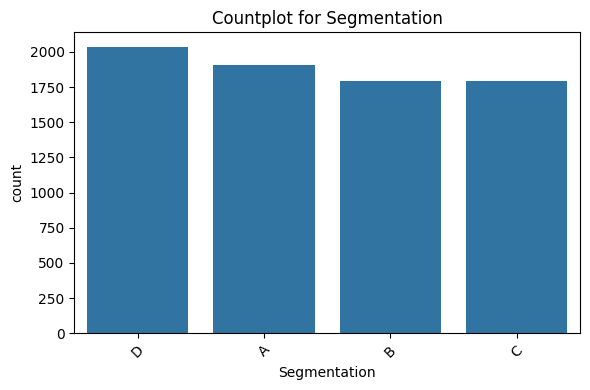

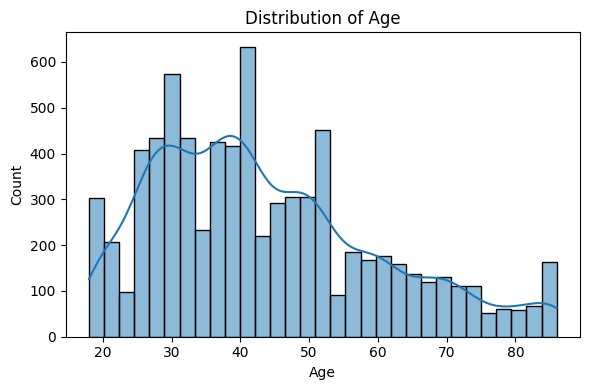

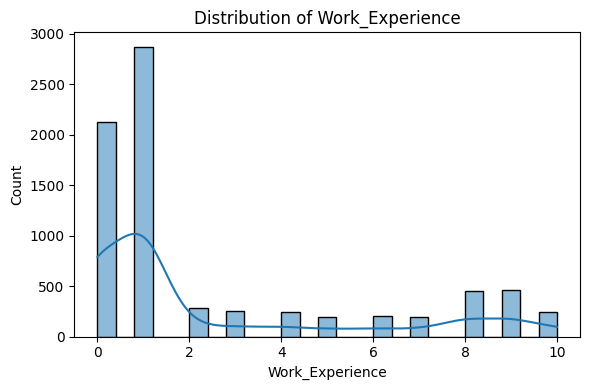

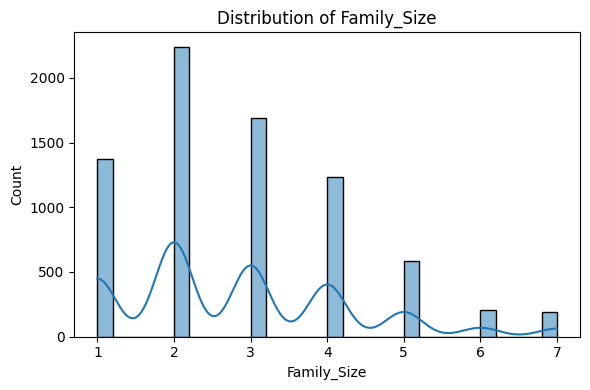

In [108]:
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']
numerical_cols = ['Age', 'Work_Experience', 'Family_Size']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot for {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

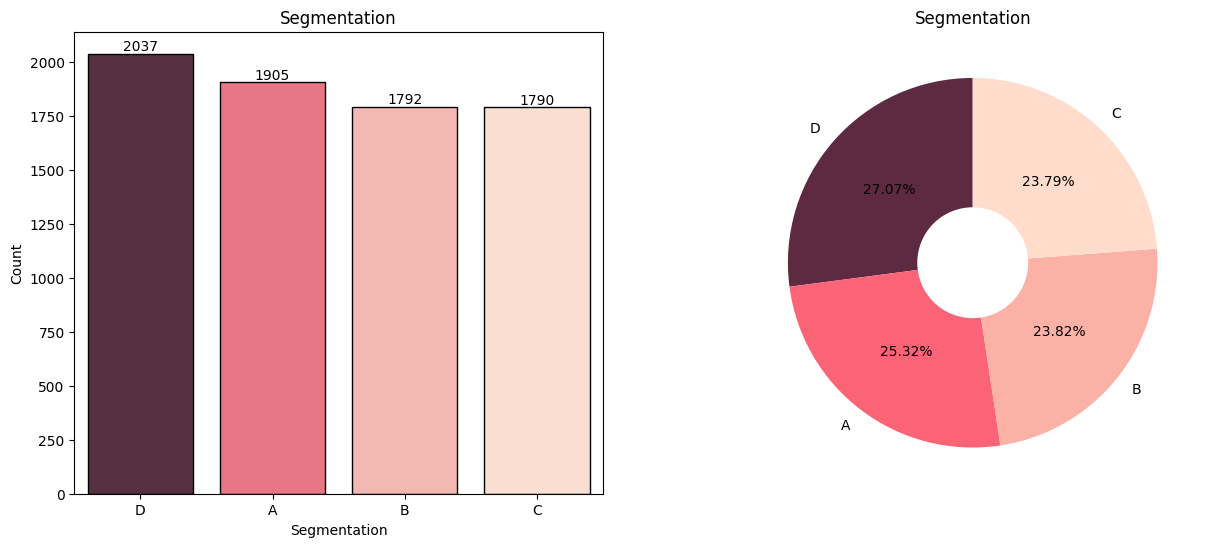

In [109]:

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
segmentation = df['Segmentation'].value_counts()
sns.barplot(x= segmentation.index, y=segmentation.values ,hue=segmentation.index, palette = ['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"], edgecolor='black', legend=False)
plt.title('Segmentation', fontweight='black', size=15)
for i, v in enumerate(segmentation.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.xlabel('Segmentation')
plt.ylabel('Count')
plt.title('Segmentation')
plt.subplot(1,2,2)
plt.pie(segmentation.values, labels=segmentation.index, autopct='%.2f%%', colors=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"], shadow=False, startangle=90)
center_circle = plt.Circle((0,0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title('Segmentation')
plt.show()

## Bivariate Analysis

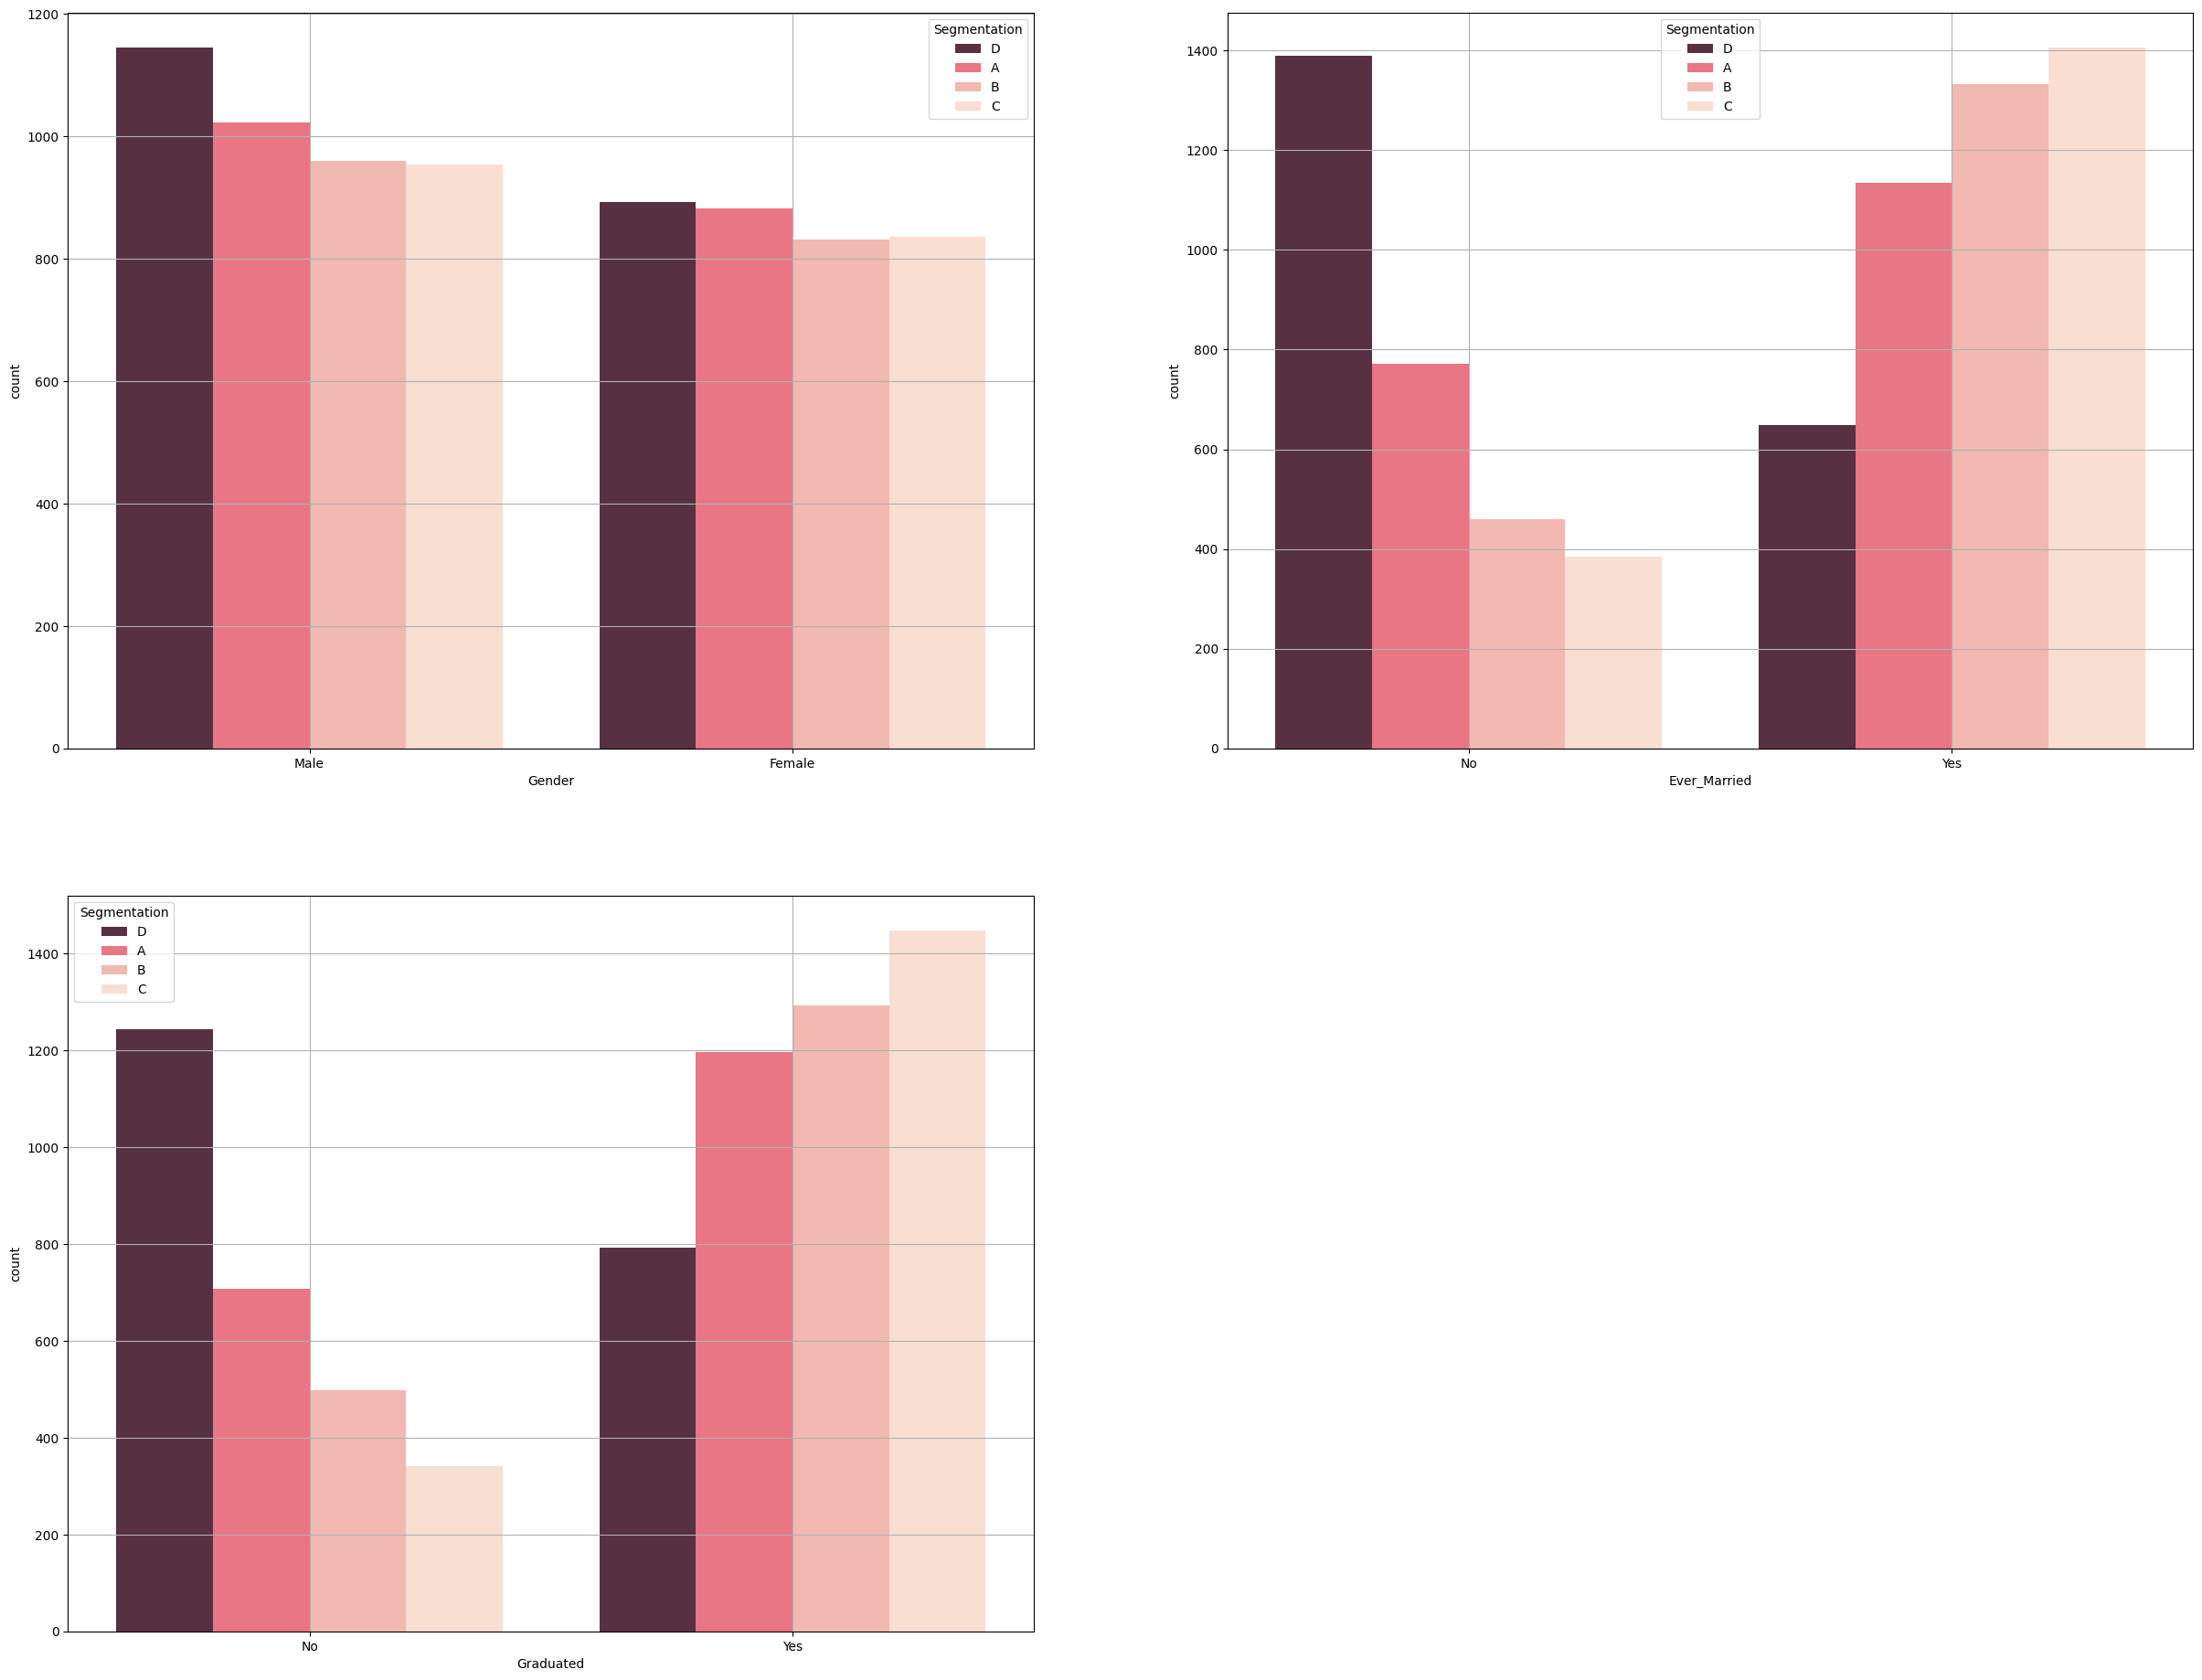

In [110]:
plt.figure(figsize=(30,23))

plt.subplot(2,2,1)
data = df['Segmentation']
sns.countplot(data=df, x='Gender', hue='Segmentation', palette=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"])
plt.grid(True)

plt.subplot(2,2,2)
data = df['Segmentation']
sns.countplot(data=df, x='Ever_Married', hue='Segmentation', palette=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"])
plt.grid(True)

plt.subplot(2,2,3)
data = df['Segmentation']
sns.countplot(data=df, x='Graduated', hue='Segmentation', palette=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"])
plt.grid(True)

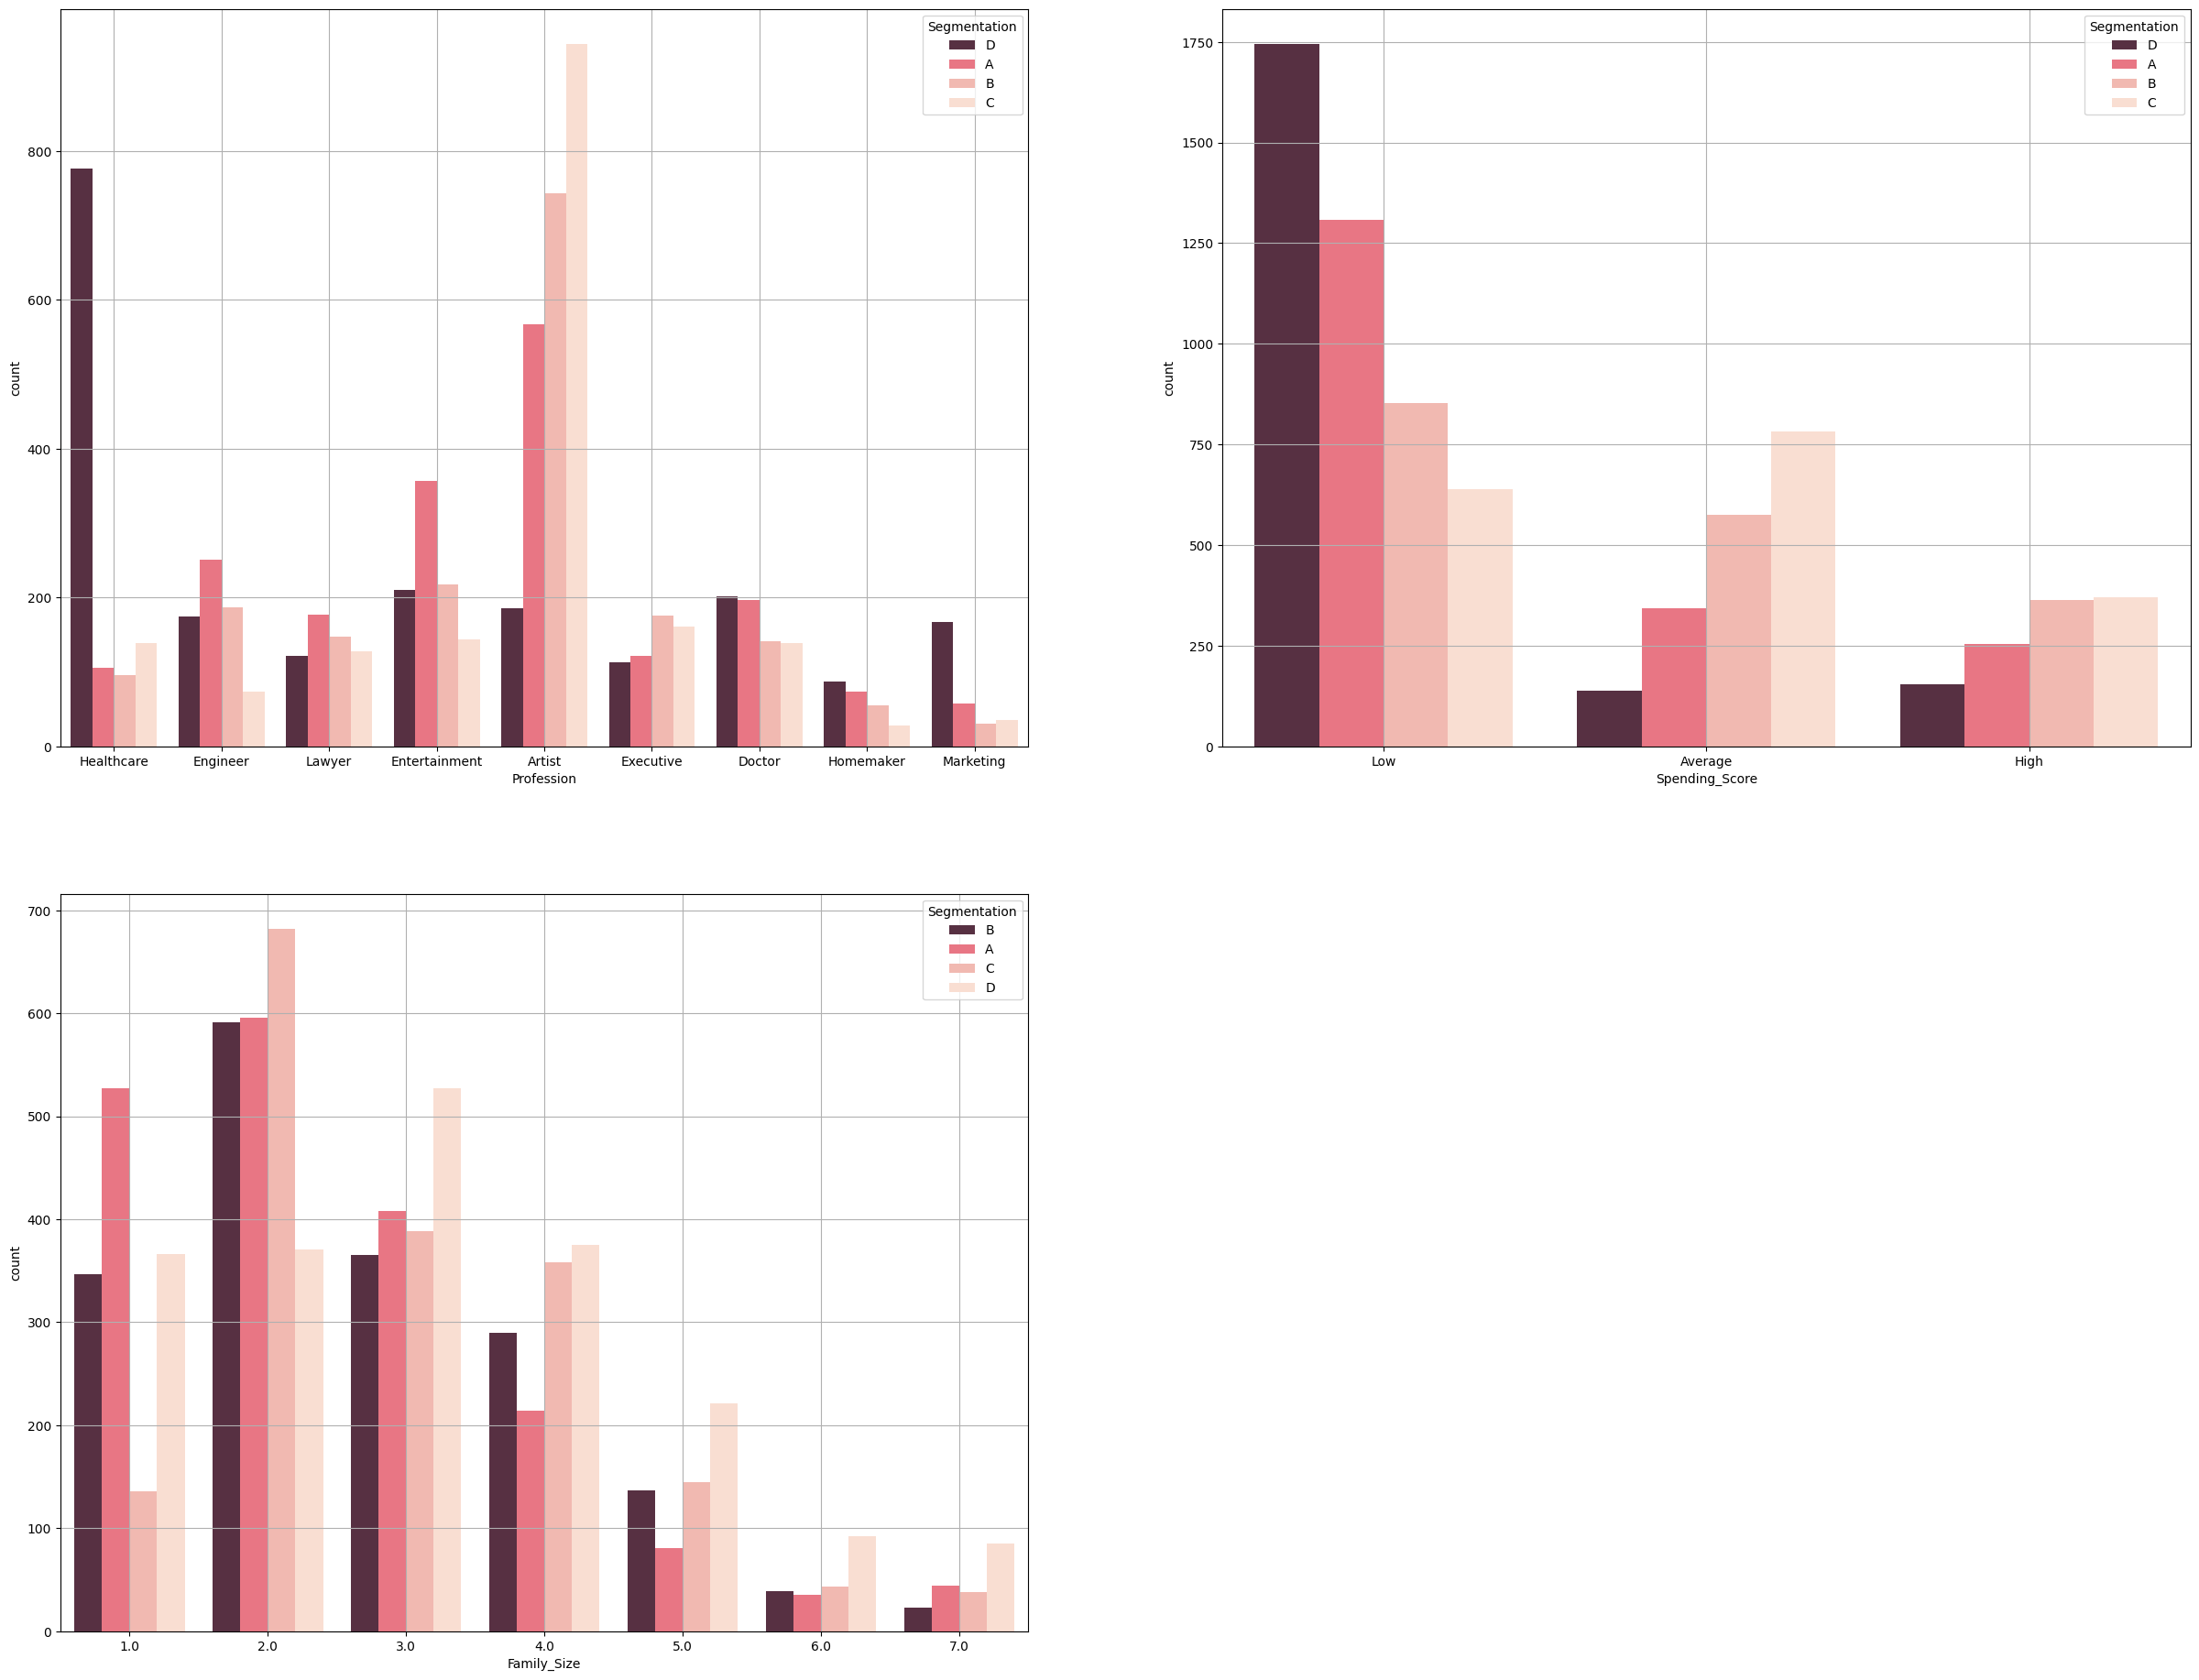

In [111]:
plt.figure(figsize=(30,23))

plt.subplot(2,2,1)
data = df['Segmentation']
sns.countplot(data=df, x='Profession', hue='Segmentation', palette=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"])
plt.grid(True)

plt.subplot(2,2,2)
data = df['Segmentation']
sns.countplot(data=df, x='Spending_Score', hue='Segmentation', palette=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"])
plt.grid(True)

plt.subplot(2,2,3)
data = df['Segmentation']
sns.countplot(data=df, x='Family_Size', hue='Segmentation', palette=['#5D2A42',"#FB6376",'#FCB1A6',"#FFDCCC"])
plt.grid(True)

In [112]:
df.groupby('Segmentation')['Gender'].value_counts()

Segmentation  Gender
A             Male      1023
              Female     882
B             Male       960
              Female     832
C             Male       954
              Female     836
D             Male      1145
              Female     892
Name: count, dtype: int64

- Gender Segmentation : In every segmentation category 'Female' is dominated by 'Male'

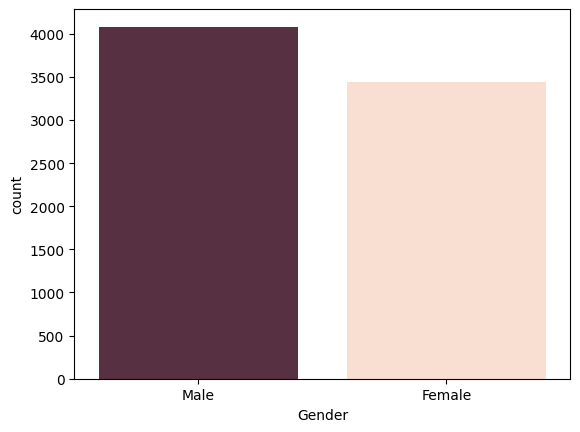

In [113]:
sns.countplot(x='Gender', data=df, hue = 'Gender', palette=['#5D2A42','#FFDCCC'])
plt.show()

In [114]:
df.groupby('Segmentation')['Graduated'].value_counts()

Segmentation  Graduated
A             Yes          1197
              No            708
B             Yes          1294
              No            498
C             Yes          1448
              No            342
D             No           1245
              Yes           792
Name: count, dtype: int64

- Graduate Segmentation : Graduates are more than non-graduates

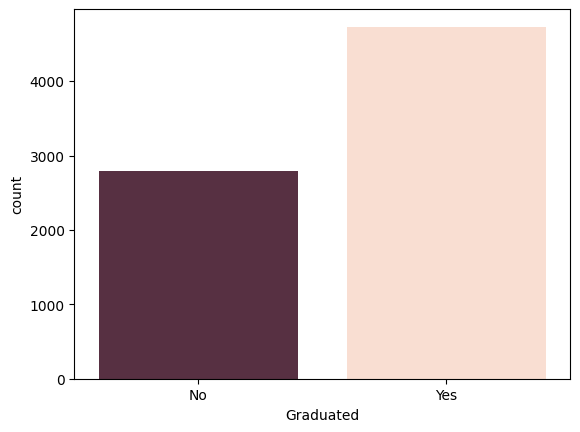

In [115]:
sns.countplot(x='Graduated', data=df,hue='Graduated', palette = ['#5D2A42','#FFDCCC'])
plt.show()

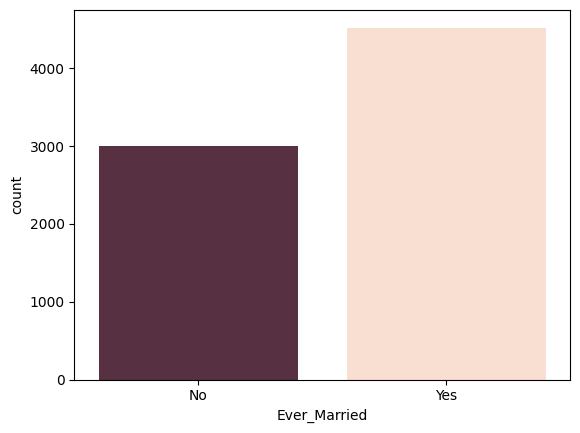

In [116]:
sns.countplot(x='Ever_Married', data=df, hue='Ever_Married',palette = ['#5D2A42','#FFDCCC'])
plt.show()

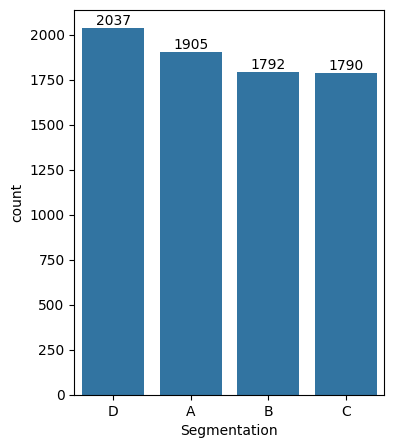

In [117]:
plt.figure(figsize=(4,5))
ax = sns.countplot(data=df, x='Segmentation')
ax.bar_label(ax.containers[0])
plt.show()

### Encode Categorial Variable

In [118]:
df_encoded = df.copy()

In [119]:
df_encoded = df.copy()
label_cols = ['Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded['Segmentation_Label'] = le.fit_transform(df_encoded['Segmentation'])

In [120]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = df_encoded.drop(['Segmentation','Gender'], axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Use PCA for 2D visualization
pca = PCA(n_components=0.95, random_state=42)
X_pca= pca.fit_transform(X_scaled)

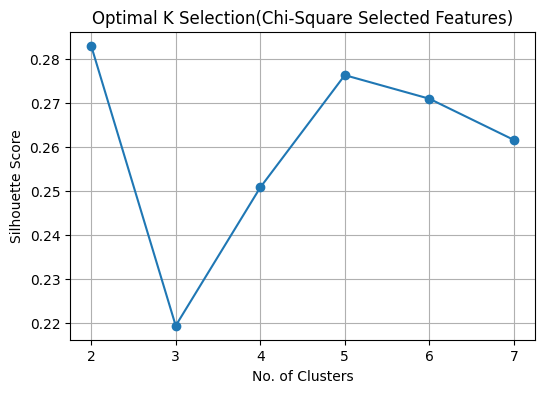

Final Silhouette Score: 0.2831013670353051


In [121]:
# Determine optimal k using Silhouette Score
scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    scores.append((k, score))

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(*zip(*scores), marker='o')
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal K Selection(Chi-Square Selected Features)')
plt.grid(True)
plt.show()

optimal_k = max(scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
print("Final Silhouette Score:", max(scores, key=lambda x: x[1])[1])

In [122]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [0.3, 0.5, 0.7, 0.9, 1.1]
min_samples = 5

print("Trying different eps values for DBSCAN:")
for eps in eps_values:
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X_scaled)

# Ignore if DBSCAN gives only one cluster or all -1
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [0.3, 0.5, 0.7, 0.9, 1.1]
min_samples = 5

print("Trying different eps values for DBSCAN:")
for eps in eps_values:
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  labels = dbscan.fit_predict(X_scaled)

  # Ignore if DBSCAN gives only one cluster or all -1
  if len(set(labels)) <= 1 or np.unique(labels).tolist() == [-1]:
      print(f"eps={eps} → Only noise or one cluster detected")
      continue

  score = silhouette_score(X_scaled, labels)
  print(f"eps={eps} → Clusters: {len(set(labels))}, Silhouette Score: {score:.3f}")
print(f"eps={eps} → Clusters: {len(set(labels))}, Silhouette Score: {score:.3f}")


Trying different eps values for DBSCAN:
Trying different eps values for DBSCAN:
eps=0.3 → Clusters: 82, Silhouette Score: -0.045
eps=0.5 → Clusters: 5, Silhouette Score: 0.291
eps=0.7 → Clusters: 4, Silhouette Score: 0.295
eps=0.9 → Clusters: 4, Silhouette Score: 0.295
eps=1.1 → Only noise or one cluster detected
eps=1.1 → Clusters: 1, Silhouette Score: 0.295


Feature Engineering

In [123]:
X_columns = X.columns
df_scaled = pd.DataFrame(X_scaled, columns=X_columns)

df_scaled['Spending_Per_Age'] = df_scaled['Spending_Score'] / (df_scaled['Age'] + 1)
df_scaled['Profession_Age_Interaction'] = df_scaled['Profession'] * df_scaled['Age']

In [124]:
#re-running PCA
pca = PCA(n_components=0.95, random_state=42)
X_pca_new = pca.fit_transform(df_scaled)

In [125]:
#KMeans++
kmeans_plus = KMeans(n_clusters=2, init='k-means++', random_state=42)
labels_new = kmeans_plus.fit_predict(X_pca_new)

score = silhouette_score(X_pca_new, labels_new)
print("Silhouette Score after Feature Engineering:", round(score, 3))

Silhouette Score after Feature Engineering: 0.296


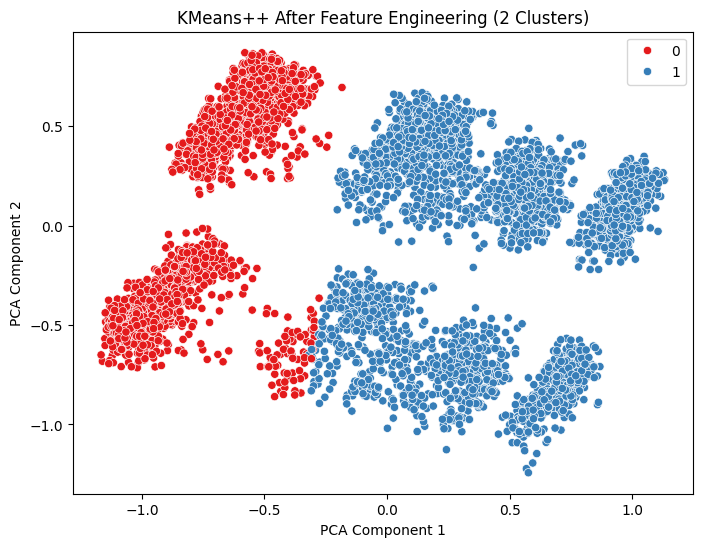

In [126]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_new[:, 0], y=X_pca_new[:, 1], hue=labels_new, palette='Set1')
plt.title("KMeans++ After Feature Engineering (2 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

One-Hot-Encoding and KMeans

In [127]:
#Trying One-Hot-Encoding with and without PCA to get increased Silhoutte Score by using KMeans++
import pandas as pd

# Replace these with your actual categorical columns
categorical_cols = ['Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


df_one_hot_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [128]:
df_one_hot_encoded = df_one_hot_encoded.drop('Gender', axis=1)

In [129]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

# Drop the 'Segmentation' column before scaling
scaled_data = scaler.fit_transform(df_one_hot_encoded.drop('Segmentation', axis=1))

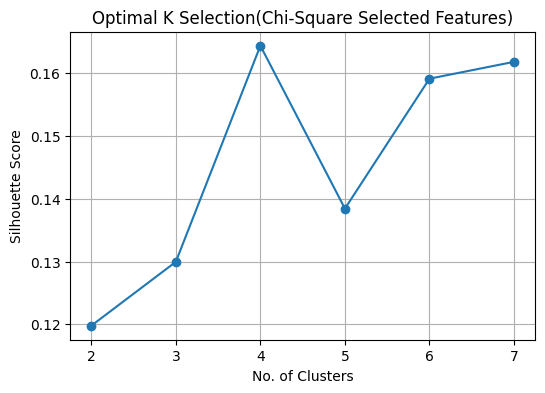

Final Silhouette Score: 0.16437030009766557


In [130]:
# Determine optimal k using Silhouette Score
scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, preds)
    scores.append((k, score))

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(*zip(*scores), marker='o')
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal K Selection(Chi-Square Selected Features)')
plt.grid(True)
plt.show()

optimal_k = max(scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
print("Final Silhouette Score:", max(scores, key=lambda x: x[1])[1])

In [131]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(scaled_data)

score = silhouette_score(scaled_data, labels)
print("Silhouette Score after One-Hot-Encoding:", round(score, 3))

Silhouette Score after One-Hot-Encoding: 0.164


#### Tried One-Hot-Encoding with KMeans, and resulted in 0.164 silhouette score

AGGLOMERATIVE CLUSTERING

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

X = df_encoded.drop(['Segmentation','Gender'], axis=1)
y = df_encoded['Segmentation_Label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Use your encoded & cleaned dataset here

for n_clusters in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # Try linkage='average' or 'complete' too
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {score:.3f}")

Silhouette Score for 2 clusters: 0.174
Silhouette Score for 3 clusters: 0.142
Silhouette Score for 4 clusters: 0.143
Silhouette Score for 5 clusters: 0.145
Silhouette Score for 6 clusters: 0.148
Silhouette Score for 7 clusters: 0.147
Silhouette Score for 8 clusters: 0.139
Silhouette Score for 9 clusters: 0.153
Silhouette Score for 10 clusters: 0.154


## Supervised Models

In [133]:
df1 = df.copy()

In [134]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df:
    df1[col] = le.fit_transform(df1[col])

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'Cluster' is the target label from KMeans++ results
X = df1.drop('Segmentation', axis=1)
y = df1['Segmentation']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(),
    'XGBoost' : XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', randomstate = 42)
}

# Train and evaluate
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression
Accuracy: 0.48438538205980064
Confusion Matrix:
 [[164  45  68  89]
 [124  54 128  49]
 [ 60  45 200  51]
 [ 72  17  28 311]]
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.45      0.42       366
           1       0.34      0.15      0.21       355
           2       0.47      0.56      0.51       356
           3       0.62      0.73      0.67       428

    accuracy                           0.48      1505
   macro avg       0.45      0.47      0.45      1505
weighted avg       0.46      0.48      0.46      1505


Decision Tree
Accuracy: 0.413953488372093
Confusion Matrix:
 [[130 102  58  76]
 [111 104  98  42]
 [ 64  96 150  46]
 [ 81  69  39 239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.36      0.35       366
           1       0.28      0.29      0.29       355
           2       0.43      0.42      0.43       356
           3  

In [137]:
!pip install catboost

In [138]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [139]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("LightGBM Results")
print("Accuracy:", accuracy_score(y_test, lgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, lgb_preds))
print("Classification Report:\n", classification_report(y_test, lgb_preds))

LightGBM Results
Accuracy: 0.506312292358804
Confusion Matrix:
 [[154  85  47  80]
 [ 96 116 108  35]
 [ 39  68 202  47]
 [ 92  29  17 290]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.42      0.41       366
           1       0.39      0.33      0.36       355
           2       0.54      0.57      0.55       356
           3       0.64      0.68      0.66       428

    accuracy                           0.51      1505
   macro avg       0.49      0.50      0.50      1505
weighted avg       0.50      0.51      0.50      1505



In [140]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

print("\nCatBoost Results")
print("Accuracy:", accuracy_score(y_test, cat_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, cat_preds))
print("Classification Report:\n", classification_report(y_test, cat_preds))


CatBoost Results
Accuracy: 0.4950166112956811
Confusion Matrix:
 [[158  87  43  78]
 [ 97 113 107  38]
 [ 40  78 194  44]
 [ 95  30  23 280]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.43      0.42       366
           1       0.37      0.32      0.34       355
           2       0.53      0.54      0.54       356
           3       0.64      0.65      0.65       428

    accuracy                           0.50      1505
   macro avg       0.48      0.49      0.49      1505
weighted avg       0.49      0.50      0.49      1505



In [141]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [142]:
base_learners = [
('lightgbm', LGBMClassifier(verbose=-1, random_state=42)),
('catboost', CatBoostClassifier(verbose=0, random_state=42)),
('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

meta_learner = LogisticRegression()

In [143]:
stacked_model = StackingClassifier(
estimators=base_learners,
final_estimator=meta_learner,
cv=5,
n_jobs=-1
)

In [144]:
stacked_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lightgbm',
                                LGBMClassifier(random_state=42, verbose=-1)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7be050d55910>),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_catego...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [145]:
y_pred = stacked_model.predict(X_test)

In [146]:
print("Stacked Model Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Stacked Model Results
Accuracy: 0.5156146179401994
Confusion Matrix:
 [[159  80  41  86]
 [ 95 121 103  36]
 [ 40  64 208  44]
 [ 94  23  23 288]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.43      0.42       366
           1       0.42      0.34      0.38       355
           2       0.55      0.58      0.57       356
           3       0.63      0.67      0.65       428

    accuracy                           0.52      1505
   macro avg       0.50      0.51      0.51      1505
weighted avg       0.51      0.52      0.51      1505



Ensemble Accuracy: 0.5023255813953489
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.42      0.41       366
           1       0.39      0.32      0.35       355
           2       0.54      0.56      0.55       356
           3       0.63      0.67      0.65       428

    accuracy                           0.50      1505
   macro avg       0.49      0.49      0.49      1505
weighted avg       0.50      0.50      0.50      1505



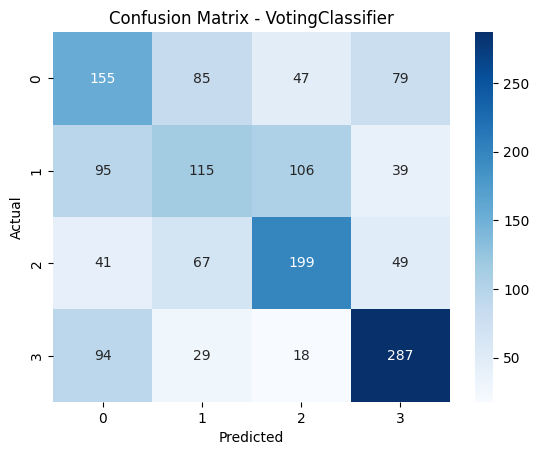

In [147]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft'  # soft gives better results for probabilities
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - VotingClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


checking class imbalance

In [148]:
df['Segmentation'].value_counts(normalize=True)

,proportion
Segmentation,
D,0.270734
A,0.253190
B,0.238171
C,0.237905


checking feature correlation

In [149]:
df.corr(numeric_only=True)

,Age,Work_Experience,Family_Size
Age,1.000000,-0.195289,-0.262680
Work_Experience,-0.195289,1.000000,-0.059453
Family_Size,-0.262680,-0.059453,1.000000


<Axes: >

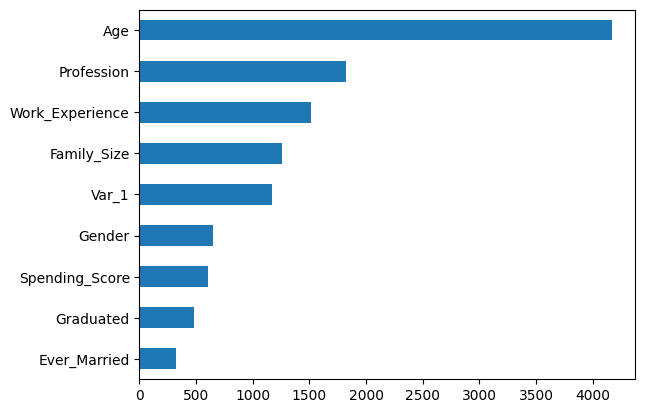

In [150]:
model = LGBMClassifier()
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh')

As Gender, Spending_Score, Graduated and Ever_Married features are having low importance, we should drop them and retrain

In [151]:
low_importance = ['Gender', 'Spending_Score', 'Graduated', 'Ever_Married']
X_train_reduced = X_train.drop(columns=low_importance)
X_test_reduced = X_test.drop(columns=low_importance)

model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test_reduced)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.48106312292358805


By dropping those features the accuracy have decreased even more, from 0.50 to 0.48

In [152]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [153]:
#Train LGBM with hyperparameter tuning
params = {
    'num_leaves': [31],
    'max_depth': [5],
    'learning_rate': [0.05],
    'n_estimators': [200],
    'reg_alpha': [0.5],
    'reg_lambda': [0.5]
}

grid = GridSearchCV(LGBMClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

model = grid.best_estimator_
y_pred = model.predict(X_test)

print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
Accuracy: 0.5229235880398672
              precision    recall  f1-score   support

           0       0.42      0.45      0.43       366
           1       0.42      0.34      0.38       355
           2       0.56      0.58      0.57       356
           3       0.64      0.69      0.67       428

    accuracy                           0.52      1505
   macro avg       0.51      0.51      0.51      1505
weighted avg       0.52      0.52      0.52      1505



This time used hyperparameter tuning with LGBM and got 0.522 accuracy

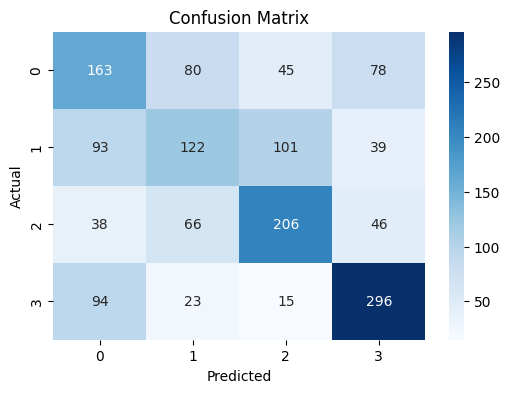

In [154]:
#Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [155]:
#SHAP Explainability
!pip install shap

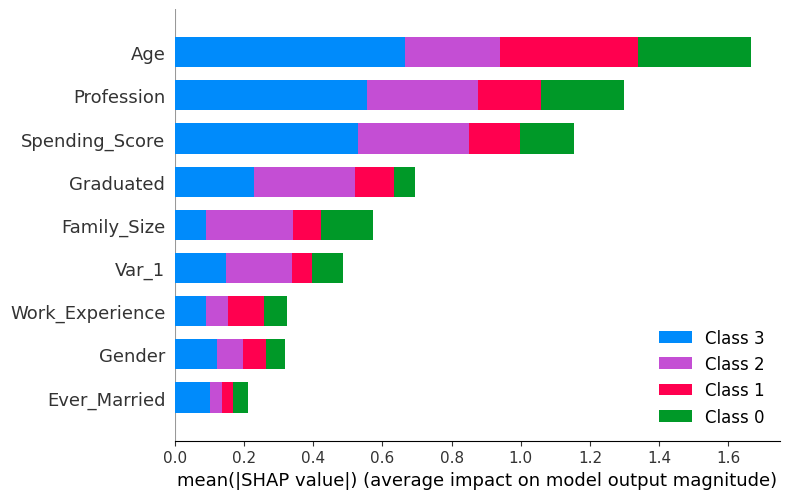

In [156]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [157]:
df['Segmentation'].value_counts()

,count
Segmentation,
D,2037
A,1905
B,1792
C,1790


In [158]:
df1.groupby('Segmentation')[['Spending_Score', 'Age', 'Work_Experience']].mean()

,Spending_Score,Age,Work_Experience
Segmentation,,,
0,1.507087,24.090814,2.646719
1,1.154576,27.230469,2.228237
2,0.919553,27.965363,2.224022
3,1.788905,14.879725,2.883652


As B(1) and C(2) are similar in Age and Work_Experience, we could combine them for better accuracy.

In [159]:
# Merge B and C into 'BC'
df['Segmentation'] = df['Segmentation'].replace({'B': 'BC', 'C': 'BC'})

# Encode the new labels
label_mapping = {'A': 0, 'BC': 1, 'D': 2}
df['Segmentation'] = df['Segmentation'].map(label_mapping)


In [160]:
df_encoded2 = df.copy()
for col in df_encoded2.select_dtypes(include='object').columns:
    df_encoded2[col] = LabelEncoder().fit_transform(df_encoded2[col])


In [161]:
print(X_train.dtypes)

Gender             int64
Ever_Married       int64
Age                int64
Graduated          int64
Profession         int64
Work_Experience    int64
Spending_Score     int64
Family_Size        int64
Var_1              int64
dtype: object


In [162]:
from sklearn.model_selection import train_test_split

X = df_encoded2.drop('Segmentation', axis=1)
y = df_encoded2['Segmentation']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Accuracy: 0.6212624584717608
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.53      0.47       381
           1       0.76      0.63      0.69       717
           2       0.64      0.69      0.66       407

    accuracy                           0.62      1505
   macro avg       0.61      0.62      0.61      1505
weighted avg       0.64      0.62      0.63      1505



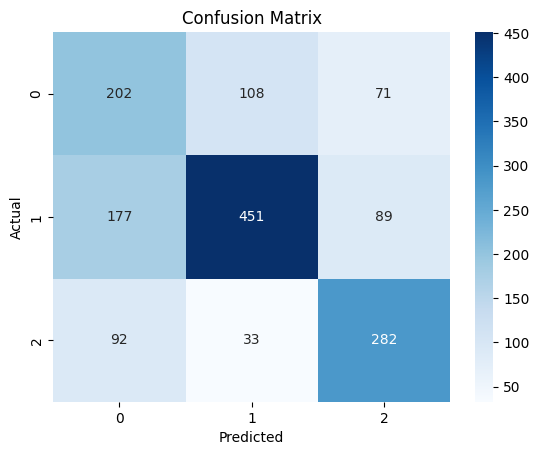

In [163]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(class_weight='balanced',
                       max_depth=4,
                       n_estimators=200,
                       random_state=42)
model.fit(X_train_encoded, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test_encoded)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Ensemble Accuracy: 0.6318936877076412
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.40      0.43       381
           1       0.69      0.76      0.72       717
           2       0.65      0.62      0.64       407

    accuracy                           0.63      1505
   macro avg       0.60      0.59      0.60      1505
weighted avg       0.62      0.63      0.63      1505



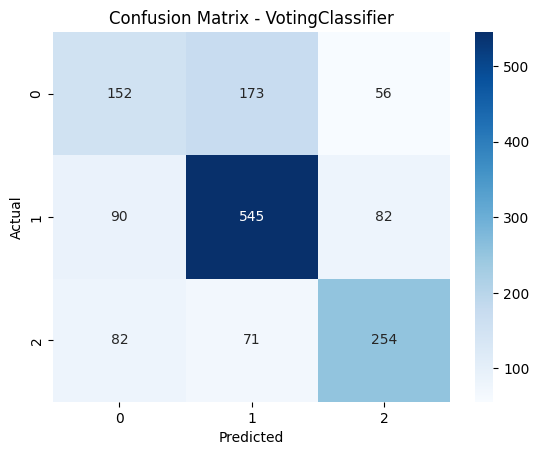

In [164]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft'  # soft gives better results for probabilities
)

ensemble.fit(X_train_encoded, y_train)
y_pred = ensemble.predict(X_test_encoded)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - VotingClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 640x480 with 0 Axes>

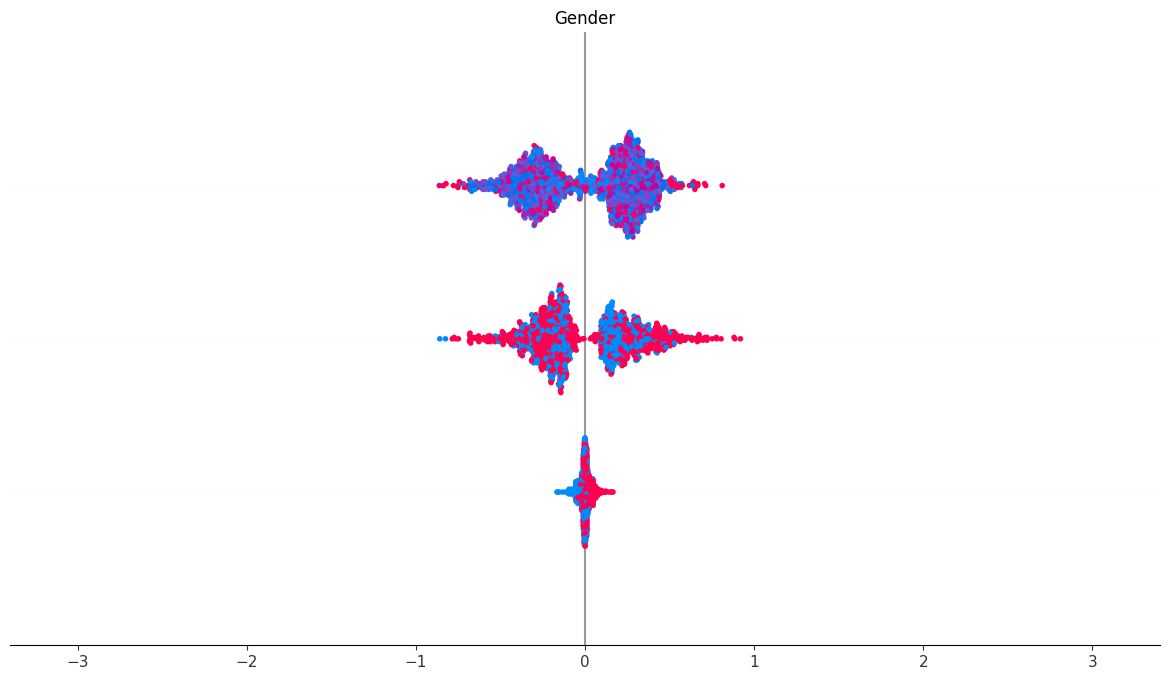

In [165]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_encoded)

# Summary plot
shap.summary_plot(shap_values, X_test_encoded)

In [166]:
df['Segmentation'].value_counts(normalize=True)

,proportion
Segmentation,
1,0.476077
2,0.270734
0,0.253190


In [167]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split using df_encoded2
X = df_encoded2.drop('Segmentation', axis=1)
y = df_encoded2['Segmentation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Resample to balance using df_encoded2
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train model
model = LGBMClassifier(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_resampled, y_resampled)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6353003721424774
              precision    recall  f1-score   support

           0       0.46      0.43      0.44       476
           1       0.72      0.73      0.72       896
           2       0.63      0.67      0.65       509

    accuracy                           0.64      1881
   macro avg       0.61      0.61      0.61      1881
weighted avg       0.63      0.64      0.63      1881



In [168]:
# Third model (final with A, BC, D)
model3 = LGBMClassifier()
model3.fit(X_resampled, y_resampled)


LGBMClassifier()

In [169]:
import joblib
joblib.dump(model3, 'model3.pkl')

['model3.pkl']

In [170]:
import numpy as np

preds = model.predict(X_test_encoded)
unique, counts = np.unique(preds, return_counts=True)
print("Prediction distribution:", dict(zip(unique, counts)))


Prediction distribution: {np.int64(0): np.int64(354), np.int64(1): np.int64(719), np.int64(2): np.int64(432)}


In [171]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the predictions from the model trained in cell B0vIrbIM08iT
# The variable y_pred in cell B0vIrbIM08iT contains the predictions on X_test
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.43      0.44       476
           1       0.72      0.73      0.72       896
           2       0.63      0.67      0.65       509

    accuracy                           0.64      1881
   macro avg       0.61      0.61      0.61      1881
weighted avg       0.63      0.64      0.63      1881

Confusion Matrix:
[[203 189  84]
 [131 653 112]
 [106  64 339]]
